In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from datasets import load_dataset


def load_data():
    """
    Load the Iris dataset from Hugging Face (or fallback to sklearn if needed).
    Returns: (X, y, feature_names, class_names, dataframe)
    """
    try:
        ds = load_dataset("scikit-learn/iris")
        df = pd.DataFrame(ds["train"])
    except Exception as e:
        print("Could not load from HuggingFace, using sklearn dataset. Error:", e)
        from sklearn.datasets import load_iris
        sk = load_iris()
        df = pd.DataFrame(sk.data, columns=sk.feature_names)
        df["target"] = sk.target
        target_names = sk.target_names
        df["species"] = [target_names[i] for i in sk.target]


    if "Species" in df.columns:
        df = df.rename(columns={"Species": "species"})
    if "target" in df.columns and "species" not in df.columns:
        le = LabelEncoder()
        df["species"] = le.fit_transform(df["target"])
    # Extract features and labels
    feature_cols = [c for c in df.columns if c not in ("species", "target", "Id")]
    X = df[feature_cols].values
    y = df["species"].values
    class_names = np.unique(y)
    return X, y, feature_cols, class_names, df



In [12]:
def preprocess(X, y):
    """
    Do any preprocessing: label encode, standardize if required, train/test split, etc.
    Returns: X_train, X_test, y_train, y_test, scaler (if used)
    """
    # encode y
    if isinstance(y[0], str):
        le = LabelEncoder()
        y_enc = le.fit_transform(y)
        class_names = le.classes_
    else:
        y_enc = y
        class_names = np.unique(y)
        le = None

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
    )

    # Standardization
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    return X_train_s, X_test_s, y_train, y_test, scaler, class_names


In [13]:
def apply_lda(X_train, y_train, X_test, n_components=None):
    """
    Fit LDA on the training set, transform training and test, return model and transformed data.
    n_components: number of discriminants to keep (≤ number of classes − 1)
    """
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    return lda, X_train_lda, X_test_lda

In [14]:
def evaluate(lda_model, X_test, y_test, class_names):
    """
    Predict and evaluate performance on the original test set (not LDA-transformed).
    """
    y_pred = lda_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, target_names=[str(c) for c in class_names])
    return acc, cm, cr


In [15]:

def plot_lda(X_lda, y, class_names, title="LDA: Iris projection", ax=None):
    """
    Plot the first two linear discriminants.
    X_lda: transformed data (samples × components)
    y: labels
    class_names: list of unique class labels (strings or numbers)
    """
    if X_lda.shape[1] < 2:
        raise ValueError("Need at least 2 LDA components for 2D plot")

    df_lda = pd.DataFrame({
        "LD1": X_lda[:, 0],
        "LD2": X_lda[:, 1],
        "species": y
    })
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x="LD1", y="LD2",
        hue="species",
        palette="Set1",
        data=df_lda,
        s=80,
        edgecolor="k",
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel("Linear Discriminant 1")
    plt.ylabel("Linear Discriminant 2")
    plt.legend(title="Species")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_explained_variance(lda_model):
    """
    Plot the explained variance (ratio) of linear discriminants
    """
    evr = lda_model.explained_variance_ratio_
    components = np.arange(1, len(evr)+1)
    plt.figure(figsize=(6,4))
    sns.barplot(x=components, y=evr, palette="viridis")
    plt.xlabel("Linear Discriminant Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("LDA Explained Variance Ratio")
    plt.xticks(components - 1, [f"LD{i}" for i in components])
    plt.tight_layout()
    plt.show()

Test Accuracy: 1.0
Confusion Matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]
Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



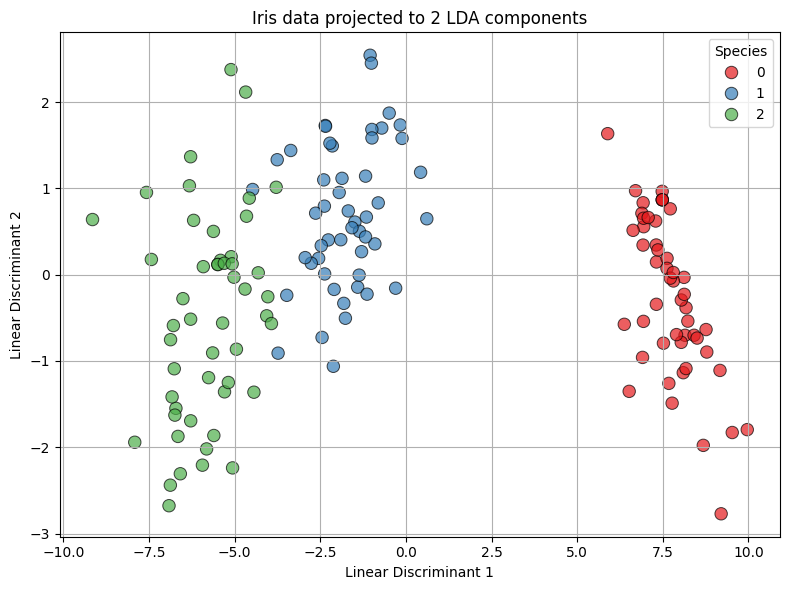

/tmp/ipython-input-3531824599.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=components, y=evr, palette="viridis")


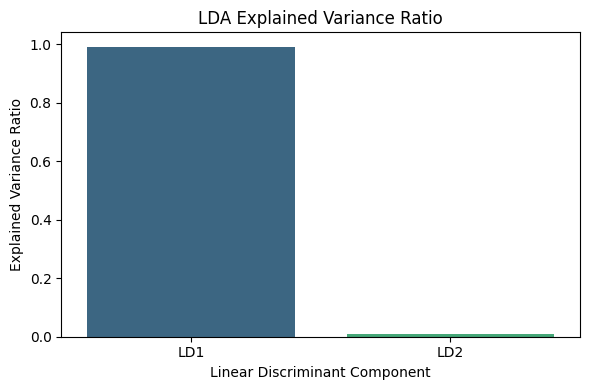

In [17]:
def main():
    # Load
    X, y, feature_cols, class_names, df = load_data()
    # Preprocess
    X_train, X_test, y_train, y_test, scaler, class_names_enc = preprocess(X, y)
    # Apply LDA
    lda_model, X_train_lda, X_test_lda = apply_lda(X_train, y_train, X_test, n_components=2)
    # Evaluate (pass original test features, not X_test_lda)
    acc, cm, cr = evaluate(lda_model, X_test, y_test, class_names_enc)
    print("Test Accuracy:", acc)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)
    # Visualization
    X_all_lda = lda_model.transform(np.vstack((X_train, X_test)))
    y_all = np.concatenate((y_train, y_test))
    plot_lda(X_all_lda, y_all, class_names_enc, title="Iris data projected to 2 LDA components")
    plot_explained_variance(lda_model)



if __name__ == "__main__":
    main()